In [1]:
%matplotlib inline
import numpy as np
import pypianoroll as pr
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [2]:
def load_vocal_file(file_path=str(),iterate_num=0):
    time_array = []
    hz_array = []
    midi_array= []
    file_name = []
    file_count = 0
    
    if len(file_path)==0:
        for root,dirs,files in os.walk("./lmd_matched/", topdown=False):
            for name in files:
                full_name = os.path.join(root,name)
                if file_count == iterate_num and full_name.endswith('.npz'):
                    with np.load(full_name) as data:
                        print("loading data")
                        time_array = data['time']
                        hz_array = data['hz']
                        midi_array = data['midi']
                        print(time_array.shape)
                    png_path = os.path.join(root,'vis.png')
                    img=mpimg.imread(png_path)
                    imgplot = plt.imshow(img)
                    return full_name, time_array, hz_array, midi_array
                else:
                    if full_name.endswith('.npz'):
                        file_count += 1
                    continue
    else:
        for root,dirs,files in os.walk(file_path, topdown=False):
            for name in files:
                full_name = os.path.join(root,name)
                if full_name.endswith('.npz'):
                    with np.load(full_name) as data:
                        print("loading data")
                        time_array = data['time']
                        hz_array = data['hz']
                        midi_array = data['midi']
                        print(time_array.shape)
                    png_path = os.path.join(root,'vis.png')
                    img=mpimg.imread(png_path)
                    imgplot = plt.imshow(img)
                    return full_name, time_array, hz_array, midi_array

In [3]:
def load_midi_file(file_name):
    file_count = 0
    for root,dirs,files in os.walk("./lpd_cleansed/", topdown=False):
        for name in files:
            if file_count == 1:
                break
            full_name = os.path.join(root,name)
            if full_name.endswith('.npz'):
                temp_song = pr.load(full_name)
            for track in temp_song.tracks:
                track.binarize()
                roll = track.pianoroll.T[:,0:600]
            file_count += 1
    print("Number of total files: "+str(file_count))               


In [16]:
def check_midi_with_single_mel():
    file_count = 0
    single_mel_songs = 0
    melody_count = 0
    midi_with_single_mel=[]
    for root,dirs,files in os.walk("./lpd_cleansed/", topdown=False):
        for name in files:
#             if file_count == 1:
#                 break
            full_name = os.path.join(root,name)
            if full_name.endswith('.npz'):
                temp_song = pr.load(full_name)
            melody_count = 0
            for track in temp_song.tracks:
                if track.name.lower() == 'melody'and melody_count<=1:
                    melody_count+=1
                    print(melody_count,track.name)
                elif melody_count >= 2:
#                     print(melody_count,"exceeds two melody tracks")
                    break
            if melody_count == 1:
                single_mel_songs += 1
                print("In",file_count,"songs, ",single_mel_songs," single melody song found:",full_name)
                midi_with_single_mel.append(full_name)
                
            file_count += 1
    print("Number of total files: "+str(single_mel_songs)) 
    return(midi_with_single_mel)

In [5]:
def test_file(filename):
    
    for root,dirs,files in os.walk(filename, topdown=False):
        for name in files:
            highest_list = []
            full_name = os.path.join(root,name)
            if not full_name.endswith("labeled.npz"):
                print(full_name)
                test_song = pr.load(full_name)
                for track in test_song.tracks:
                    track.binarize()
                    highest = []
                    print(track.name)
                    roll = track.pianoroll.T
                    for x in range(roll.shape[1]):
                        if np.argwhere(roll[:,x]).size == 0:
                            highest.extend([0])
                        else:
                            for y in range(127,-1,-1):
                                if roll[y,x] != 0:
                                    highest.extend([y])
                                    break
                    print(len(np.argwhere(highest)))
                    highest_list.append(highest)
                highest_list = np.array(highest_list)
                return test_song,highest_list

In [6]:
def spring(x,y):
    #define distances, accumulated cost and starting position matrices, with the Y sequence augmented
    y = np.insert(y,0,-1)
    distances = np.zeros((len(y), len(x)))
    starting = np.zeros((len(y), len(x)))
    accumulated_cost = np.zeros((len(y), len(x)))
    accumulated_cost[0,0] = distances[0,0]
    
    #calculate distances
    for j in range(len(y)):
        for i in range(len(x)):
            if j==0:
                distances[j,i] = 0
                starting[j,i] = i
            else:
                distances[j,i] = (x[i]-y[j])**2
            

    accumulated_cost[0,:] = 0
    accumulated_cost[1:len(y),0] = np.inf

    for i in range(1, len(y)):
        for j in range(1, len(x)):
            dbest = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1])
            starting[i,j] = {
                accumulated_cost[i-1, j-1]:starting[i-1,j-1],
                accumulated_cost[i-1, j]:starting[i-1,j],
                accumulated_cost[i, j-1]:starting[i,j-1]
            }.get(dbest,"Error")
            accumulated_cost[i, j] =  dbest + distances[i, j]
    
    end_pos = np.argmin(accumulated_cost[len(y)-1,:])
#     print(end_pos)
    path = [[end_pos,len(y)-1]]
    cost = 0
    i = len(y)-1
    j = end_pos
    while i>0 and j>0:
        if i==0:
            break
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j = j- 1
        path.append([j, i])
    for [k, h] in path:
        cost = cost + distances[h,k]
    starting_point = starting[len(y)-1,end_pos]

    return path, cost, accumulated_cost, starting_point, end_pos

In [7]:
def cmp_plot(x,y):
    plt.plot(x,'r', label='x')
    plt.plot(y, 'g', label='y')
    plt.legend();
    return
# cmp_plot(midi_array[0:2500],highest_list[2,2500:4500])
# plt.subplot(2,1,1)
# cmp_plot(np.diff(midi_array[0:2500]),np.diff(highest_list[2,3000:5000]))

In [8]:
def paa(array,window,**kwargs):
    new_array = []
    for key, value in kwargs.items():
        key = value
    blocks = int(len(array)/window)
#     print("blocks: ", blocks)
    for x in range(blocks):
        window_mean = array[x:x+window].mean()
#         print(window_mean)
        new_array.append(window_mean)
#         print(len(new_array))
        x += window
    new_array = np.array(new_array)
    return(new_array)

In [9]:
def paa_with_step(array,window,**kwargs):
    new_array = []
    for key, value in kwargs.items():
        step = value
    for x in range(len(array)):
        if x % step ==0:
            window_mean = array[x:x+window].mean()
            new_array.append(window_mean)
    new_array = np.array(new_array)
    return(new_array)

In [10]:
def sliding_window(array,window,**kwargs):
    print("original length: ", len(array))
    for key, value in kwargs.items():
        threshold = value
        print("key: ",key)
        print("value: ",value)
    new_array = [array[0]]
    i=0
    for x in array:
        if abs(x-new_array[i]) >= threshold:
            new_array.append(x)
    new_array = np.array(new_array)
    print(new_array.shape)
    return(new_array)
    

In [11]:
def smooth(midi_array,highest_list):
    window_width = 40
    midi_smooth = []
    highest_smooth = []
    for i in range(len(midi_array)-window_width):
        midi_smooth.append(midi_array[i:i+window_width].mean())
#         print(midi_smooth)
    for i in range(len(highest_list[4,:])-window_width):
        highest_smooth.append(highest_list[2,:][i:i+window_width].mean())
#         print(highest_smooth)
    midi_smooth = np.diff(midi_smooth)
    highest_smooth = np.diff(highest_smooth)
    return midi_smooth,highest_smooth

In [12]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar();

In [13]:
# path, cost, accumulated_cost, start_pos, end_pos, distances, x, y = spring(np.diff(highest_list[2,:]),np.diff(midi_array[0:1500]))
# path, cost, accumulated_cost, start_pos, end_pos, distances, x, y = spring(np.diff(highest_list[x,:],midi_smooth[0:1500])
def process_one_song(midi_array, highest_list,debug=1, window_len=2,func=paa,**kwargs):
    cost_array = []
    print("function using ",func)
    midi_paa = func(midi_array[0:1500], window_len,**kwargs)
    for x in range(highest_list.shape[0]):
        if debug:
            start_time = time.time()
        highest_paa = func(highest_list[x,:],window_len,**kwargs)
        cost = spring(highest_paa,midi_paa)[1]
        cost_array.append(cost)
        if debug:
            print("track num: ",x)
            print("cost: ",cost)
            print("--- %s seconds ---" % (time.time() - start_time))
    matched_track = np.argmin(cost_array)
    if debug:
        start_time = time.time()
        matched_paa_array = func(highest_list[matched_track,:],window_len,**kwargs)
        matched_path, matched_cost, matched_acc_cost, start_pos, end_pos = spring(matched_paa_array,highest_list[matched_track])
        print("last spring time--- %s seconds ---" % (time.time() - start_time))
        print("matched_track: ",matched_track)
        return (matched_track,cost_array,matched_path,matched_acc_cost,start_pos, end_pos)
    else:
        return matched_track



In [14]:
def process_multiple(process_files=1,window_len=4,func=paa,**kwargs):
    file_count = 0
    found_song = 0
    
    #iterate over files
    for root,dirs,files in os.walk("./labeled_midi/", topdown=False):

        name = files[0]
        full_name = os.path.join(root,name)
        print(full_name)

        #stop when required numbers of files are reached
        if file_count == process_files:
            print(full_name," reached")
            print("file_count: ", file_count)
            print("process_file: ", process_files)
            break
        else:
            
            #set vocal path
            vocal_path = "./lmd_matched/"+"/".join(full_name.split('/')[2:-1])+'/MeExt.npz'
#             print(vocal_path)

            #continue when vocal_path is not an existing file
            if not (os.path.isfile(vocal_path)):
                continue

            start_time = time.time()
            midi_matched = []
            highest_list = []

            #set vocal midi array
            with np.load(vocal_path) as data:
                    midi_array = data['midi']

            #find labeled track
            if full_name.endswith('.mid'):
                temp_song = pr.parse(full_name)
                track_num = 0
                for track in temp_song.tracks:
                    track.binarize()
                    highest = []
#                     print(track.name)
                    roll = track.pianoroll.T
                    for x in range(roll.shape[1]):
                        if np.argwhere(roll[:,x]).size == 0:
                            highest.extend([0])
                        else:
                            for y in range(127,-1,-1):
                                if roll[y,x] != 0:
                                    highest.extend([y])
                                    break
#                     print(len(np.argwhere(highest)))
                    highest_list.append(highest)

                    if track.name.lower() == 'melody':
                        midi_matched.append(track_num)
#                         print("Matched track from midi: ",track_num)
                    track_num += 1
            highest_list = np.array(highest_list)
            if len(midi_matched) == 0:
                print("No melody track found in midi.")
                print("processed ",file_count, " files")
                print("--- %s seconds ---" % (time.time() - start_time))
                continue
            print("Matched track from midi: ",midi_matched)

            matched = process_one_song(midi_array, highest_list,debug=0,window_len=window_len,func=func,**kwargs)
            print("Matched track from vocal: ",matched)
            if matched in midi_matched:
                print("match found, the track is", matched)
                found_song += 1
            else:
                print("match failed")

            file_count += 1
            print("processed ",file_count, " files")
            print("--- %s seconds ---" % (time.time() - start_time))
        
    print("Matched rate: ", found_song/file_count)
process_multiple(process_files=2,window_len=50,func=paa)

./labeled_midi/R/R/U/TRRRUTV12903CEA11B/a8a167f3ab4d81560b65095e7565a837.mid
Matched track from midi:  [2, 4]
function using  <function paa at 0x114077e18>
Matched track from vocal:  5
match failed
processed  1  files
--- 3.9624881744384766 seconds ---
./labeled_midi/R/R/U/TRRRUFD12903CD7092/6c460e4c53ab8c0b87f080b31ee89506.mid
Matched track from midi:  [0, 2]
function using  <function paa at 0x114077e18>
Matched track from vocal:  1
match failed
processed  2  files
--- 1.0751152038574219 seconds ---
./labeled_midi/R/R/U/.DS_Store
./labeled_midi/R/R/U/.DS_Store  reached
file_count:  2
process_file:  2
Matched rate:  0.0


In [15]:
process_multiple(process_files=5,window_len=5,func=paa)

./labeled_midi/R/R/U/TRRRUTV12903CEA11B/a8a167f3ab4d81560b65095e7565a837.mid
Matched track from midi:  [2, 4]
function using  <function paa at 0x114077e18>


KeyboardInterrupt: 

In [17]:
midi_with_single_mel = check_midi_with_single_mel()

1 Melody
In 1 songs,  1  single melody song found: ./lpd_cleansed/R/R/U/TRRRUTV12903CEA11B/a8a167f3ab4d81560b65095e7565a837.npz_labeled.npz
1 Melody
In 24 songs,  2  single melody song found: ./lpd_cleansed/R/R/W/TRRRWOC128F42671E3/5b33e0d60257d60162ec502ab1ff6e2e.npz
1 MELODY
In 59 songs,  3  single melody song found: ./lpd_cleansed/R/U/B/TRRUBZB128E078B30B/1a2d93e76bf6f906e2ff27bada43d14b.npz
1 MELODY
In 116 songs,  4  single melody song found: ./lpd_cleansed/R/N/D/TRRNDQT128F42691FC/0cef2e7cc3950dbc9fe92c0314850961.npz
1 MELODY
In 117 songs,  5  single melody song found: ./lpd_cleansed/R/N/D/TRRNDQO128F93521F5/77e3ec94f04c38682a68c57c1851fe9d.npz
1 Melody
In 131 songs,  6  single melody song found: ./lpd_cleansed/R/G/U/TRRGUDF12903CA8191/903cd2bf00b6035ee701e9634f0f0793.npz
1 MELODY
In 135 songs,  7  single melody song found: ./lpd_cleansed/R/G/G/TRRGGKE12903CAC76F/766e14848d4c5fc4a80ae2b99edf967c.npz
1 Melody
In 155 songs,  8  single melody song found: ./lpd_cleansed/R/G/B/TRRGBLN1

1 MELODY
In 1028 songs,  64  single melody song found: ./lpd_cleansed/U/S/R/TRUSRJK128F932D4CF/e8fafcc6f63041de36fa119deb97e8c8.npz
1 Melody
In 1044 songs,  65  single melody song found: ./lpd_cleansed/U/S/J/TRUSJAU128F4262FC8/8300305c4350736ed363afc0f26abd30.npz
1 MELODY
In 1060 songs,  66  single melody song found: ./lpd_cleansed/U/S/P/TRUSPZB128F92E7B0C/14d1986ed88de6ca5c65b6eea62c584c.npz
1 MELODY
In 1090 songs,  67  single melody song found: ./lpd_cleansed/U/A/K/TRUAKBS128F424357F/e004a562d649c3819e116cc9fa823ee8.npz
1 Melody
In 1092 songs,  68  single melody song found: ./lpd_cleansed/U/A/W/TRUAWTS128F4295701/d2fb87c377a574baed606036457aa62a.npz
1 Melody
In 1131 songs,  69  single melody song found: ./lpd_cleansed/U/O/I/TRUOIPK12903CAB41E/b678f37c20976e4949ec2307677c51d1.npz
1 MELODY
In 1135 songs,  70  single melody song found: ./lpd_cleansed/U/O/G/TRUOGNN128F145B34C/950af5aece2fa97f697b81187b1aba9c.npz
1 MELODY
In 1149 songs,  71  single melody song found: ./lpd_cleansed/U/O/Q/

1 MELODY
In 1888 songs,  127  single melody song found: ./lpd_cleansed/I/A/H/TRIAHMR12903CB0DD0/d9bd4d92c2f075b1d8e26a2e2d3efc75.npz
1 MELODY
In 1891 songs,  128  single melody song found: ./lpd_cleansed/I/A/J/TRIAJTY128F9325448/aed1bf7a450007a3a91482a2a7dbbd1c.npz
1 Melody
In 1910 songs,  129  single melody song found: ./lpd_cleansed/I/F/I/TRIFIEQ128F92FCD06/bb05ae1951983492a1b0332d1f592ee0.npz
1 Melody
In 1920 songs,  130  single melody song found: ./lpd_cleansed/I/F/F/TRIFFZN128F42A39C9/f4ab0fd6c0c4154ecfdff6f3cd5295d3.npz
1 MELODY
In 1923 songs,  131  single melody song found: ./lpd_cleansed/I/F/M/TRIFMSG128F428BA02/804f9abd05dfd86366f0c75851e35869.npz
1 MELODY
In 1958 songs,  132  single melody song found: ./lpd_cleansed/I/O/W/TRIOWCD128E0782EEF/a5f9231aa187ea00d11675e63a3adc34.npz
1 Melody
In 1965 songs,  133  single melody song found: ./lpd_cleansed/I/H/N/TRIHNGB128F426B04F/50894b6399ee7c920b0600f0ca312e6f.npz
1 Melody
In 1969 songs,  134  single melody song found: ./lpd_cleanse

1 Melody
In 2717 songs,  190  single melody song found: ./lpd_cleansed/N/F/P/TRNFPVO12903CB2AFF/dd85125f443a288adeb34aa1e0c694d6.npz
1 Melody
In 2721 songs,  191  single melody song found: ./lpd_cleansed/N/O/R/TRNORLW128F92F13D5/1a65205f15224a7e5c689176a44c2e32.npz
1 Melody
In 2736 songs,  192  single melody song found: ./lpd_cleansed/N/O/J/TRNOJKI128F92FE972/14d8aec21248dba548e3dc3aa5a98628.npz
1 Melody
In 2739 songs,  193  single melody song found: ./lpd_cleansed/N/O/Q/TRNOQQJ128F14744DE/02440b897fb39d2013f13f83cd034e88.npz
1 Melody
2 Melody
1 Melody
In 2777 songs,  194  single melody song found: ./lpd_cleansed/N/H/V/TRNHVGJ128F42AE471/dd85125f443a288adeb34aa1e0c694d6.npz
1 Melody
In 2779 songs,  195  single melody song found: ./lpd_cleansed/N/H/V/TRNHVBM12903CDC5E3/03ba506a35c691475102c8d4410f4bdc.npz
1 MELODY
In 2829 songs,  196  single melody song found: ./lpd_cleansed/N/J/G/TRNJGTR128F145958E/bed8e3844019b38a4796784fd9e20471.npz
1 MELODY
In 2845 songs,  197  single melody song fo

1 MELODY
In 3851 songs,  251  single melody song found: ./lpd_cleansed/G/Q/S/TRGQSNO128F92DFFE9/4ebd475b864f5482483a0363680c928e.npz
1 MELODY
In 3862 songs,  252  single melody song found: ./lpd_cleansed/G/Q/V/TRGQVVO128F1491804/d152eb5b01815df42ca87d762879616b.npz
1 Melody
In 3873 songs,  253  single melody song found: ./lpd_cleansed/G/Q/K/TRGQKON128F42998BE/d2fb87c377a574baed606036457aa62a.npz
1 Melody
In 3874 songs,  254  single melody song found: ./lpd_cleansed/G/Q/Y/TRGQYCW12903CEA40F/fa08cc5d36c7ed6c73a2d156c04f582b.npz
1 MELODY
In 3897 songs,  255  single melody song found: ./lpd_cleansed/G/X/D/TRGXDLL128F14A26B0/500e7af7c2808e1866d73cc187c120a4.npz
1 MELODY
In 3904 songs,  256  single melody song found: ./lpd_cleansed/G/E/R/TRGERHM128F4287F1E/4899aa139d99f49a826a5ce8bb0bcbed.npz
1 Melody
In 3911 songs,  257  single melody song found: ./lpd_cleansed/G/E/G/TRGEGMO12903CE35E0/054101f7e98604ec3704e80169101afe.npz
1 MELODY
In 3912 songs,  258  single melody song found: ./lpd_cleanse

1 Melody
In 4567 songs,  313  single melody song found: ./lpd_cleansed/Z/J/X/TRZJXEV128F426BD8A/d701cfb35d1e35859177279170c9ceb9.npz
1 Melody
In 4570 songs,  314  single melody song found: ./lpd_cleansed/Z/J/L/TRZJLTL12903C9E411/e60123b3bedfec66b5cc32be24d2d60d.npz
1 Melody
In 4581 songs,  315  single melody song found: ./lpd_cleansed/Z/C/A/TRZCALU128F427D4E4/eb0e38e4caf7895107ef93ae0b9d1cf6.npz
1 Melody
In 4587 songs,  316  single melody song found: ./lpd_cleansed/Z/C/H/TRZCHTE12903CC30B2/3ef2e4c7aa307663f159c0bb1ef20dec.npz
1 MELODY
In 4594 songs,  317  single melody song found: ./lpd_cleansed/Z/C/D/TRZCDXA12903CEABAE/eb55c2ab3f615750e65bb66e712d7e46.npz
1 melody
In 4620 songs,  318  single melody song found: ./lpd_cleansed/Z/D/F/TRZDFYJ128F423A795/f092ed209b3fcbb4ab73e919716ee6a4.npz
1 Melody
In 4638 songs,  319  single melody song found: ./lpd_cleansed/Z/D/B/TRZDBPI128F4299324/a21d4d234392bcd3704a55603b2138fc.npz
1 Melody
In 4648 songs,  320  single melody song found: ./lpd_cleanse

1 Melody
In 5654 songs,  375  single melody song found: ./lpd_cleansed/T/P/R/TRTPRTU12903CBEF22/fa08cc5d36c7ed6c73a2d156c04f582b.npz
1 MELODY
In 5660 songs,  376  single melody song found: ./lpd_cleansed/T/P/Z/TRTPZXO128F9343675/59def4f3054386b69bbf0e7aecfdfcb7.npz
1 Melody
In 5668 songs,  377  single melody song found: ./lpd_cleansed/T/P/D/TRTPDCU128F425D724/dd85125f443a288adeb34aa1e0c694d6.npz
1 Melody
In 5669 songs,  378  single melody song found: ./lpd_cleansed/T/P/V/TRTPVPD128F92E252E/f441411e10ecccf764fc38aa12b8882e.npz
1 Melody
In 5743 songs,  379  single melody song found: ./lpd_cleansed/S/U/C/TRSUCCG128F4267F5E/c9233dfb0d6addb75338c15dd4224ebd.npz
1 MELODY
In 5744 songs,  380  single melody song found: ./lpd_cleansed/S/U/D/TRSUDOP128EF34DB7A/238486f35d8e3c37678c28599ca80446.npz
1 melody
In 5745 songs,  381  single melody song found: ./lpd_cleansed/S/U/D/TRSUDGY128F92E1728/1234b779d8ad52f8b4a73d3b10b12879.npz
1 Melody
2 Melody
1 MELODY
In 5763 songs,  382  single melody song fo

1 MELODY
In 6560 songs,  436  single melody song found: ./lpd_cleansed/A/U/Y/TRAUYAB128F4282D05/cad170e114d85170336d6f1e56fb2671.npz
1 MELODY
In 6573 songs,  437  single melody song found: ./lpd_cleansed/A/I/F/TRAIFLV12903CCFECD/3cae4f9037a72cc2db3c134b3593d3ed.npz
1 MELODY
In 6574 songs,  438  single melody song found: ./lpd_cleansed/A/I/F/TRAIFVA128F426B65F/5125a7bade391d64b837786940554dee.npz
1 Melody
In 6593 songs,  439  single melody song found: ./lpd_cleansed/A/N/U/TRANUHX12903CACA95/eee12785cfcd216f5943a8aa5b171f5b.npz
1 melody
In 6595 songs,  440  single melody song found: ./lpd_cleansed/A/N/I/TRANIVG128F1484DED/31d248a604d76d77f75553f4e26c38d7.npz
1 MELODY
In 6598 songs,  441  single melody song found: ./lpd_cleansed/A/N/G/TRANGEJ128E0788792/f991cb3523fc5fb6f5cf868a2cbff6ba.npz
1 Melody
In 6603 songs,  442  single melody song found: ./lpd_cleansed/A/N/A/TRANAPL128F147328F/828d244783fa092b23f54f2eda42259b.npz
1 MELODY
In 6640 songs,  443  single melody song found: ./lpd_cleanse

1 MELODY
In 7602 songs,  498  single melody song found: ./lpd_cleansed/F/Z/Q/TRFZQVN12903CA1F21/7c84b0611f25f20feb2039011c3bec40.npz
1 MELODY
In 7618 songs,  499  single melody song found: ./lpd_cleansed/F/T/T/TRFTTPU128F425C803/72fa56ecdbc651069a76c1842e1e6b97.npz
1 Melody
In 7628 songs,  500  single melody song found: ./lpd_cleansed/F/T/H/TRFTHJX128F92F094F/c96d1e89425d04712b099b315907615f.npz
1 Melody
In 7642 songs,  501  single melody song found: ./lpd_cleansed/F/T/B/TRFTBPJ128E078F989/afc88879216a80c4f83461ea3b3b8481.npz
1 melody
In 7653 songs,  502  single melody song found: ./lpd_cleansed/F/S/U/TRFSUID128F92F2B86/8da4d50d7d229093d640c9940bbb5847.npz
1 MELODY
In 7677 songs,  503  single melody song found: ./lpd_cleansed/F/S/L/TRFSLOX128F422ADA9/e5977830ba91819eb09b3741ad989924.npz
1 MELODY
In 7700 songs,  504  single melody song found: ./lpd_cleansed/F/A/Q/TRFAQQQ12903CD96C8/6f3fb8055bd2f4c8977118980ea8f114.npz
1 MELODY
In 7756 songs,  505  single melody song found: ./lpd_cleanse

1 MELODY
In 8734 songs,  561  single melody song found: ./lpd_cleansed/O/V/Z/TROVZJZ128F146747D/2874f86e28763dc88bffc70e591938da.npz
1 Melody
In 8748 songs,  562  single melody song found: ./lpd_cleansed/O/V/X/TROVXEG128F92DA3F7/969583449583b6ef5441a6d2d55eb964.npz
1 melody
In 8752 songs,  563  single melody song found: ./lpd_cleansed/O/V/K/TROVKRP12903CE534D/a8d59dc7cdf5a7fa327bc820f7f6efaf.npz
1 MELODY
In 8762 songs,  564  single melody song found: ./lpd_cleansed/O/Q/T/TROQTBG128F427ECF9/c80bed7709a11da91b58f734ae9dc41f.npz
1 melody
In 8766 songs,  565  single melody song found: ./lpd_cleansed/O/Q/S/TROQSHV12903D0F42A/6426c97f65269a1323149fe50c1c29da.npz
1 MELODY
In 8778 songs,  566  single melody song found: ./lpd_cleansed/O/Q/E/TROQERS128F4263D1C/b6396a88ad66df96c31288a20979b42c.npz
1 MELODY
In 8805 songs,  567  single melody song found: ./lpd_cleansed/O/X/M/TROXMLO128F429757D/15c9a9b5b552bd20ab5fc48cfef99dc0.npz
1 Melody
2 Melody
1 MELODY
In 8975 songs,  568  single melody song fo

1 MELODY
In 9781 songs,  623  single melody song found: ./lpd_cleansed/H/L/I/TRHLIQP128F92DD1DA/3332915d84132f9a83aaf01fc73ccbb8.npz
1 melody
In 9792 songs,  624  single melody song found: ./lpd_cleansed/H/L/D/TRHLDFV128F930D875/049b9b0623af506f124b17238adfa757.npz
1 MELODY
In 9800 songs,  625  single melody song found: ./lpd_cleansed/H/L/Y/TRHLYZF128F4259C80/3993bada5a164fe786fbf5c8ed480a28.npz
1 MELODY
In 9860 songs,  626  single melody song found: ./lpd_cleansed/H/P/Y/TRHPYAU128F423B71A/5805353841c8e23c788e77f7cf834fdd.npz
1 MELODY
In 9883 songs,  627  single melody song found: ./lpd_cleansed/H/W/M/TRHWMGV128F92DB31D/c7523bfd41d67de23b7e1d7575284821.npz
1 MELODY
In 9894 songs,  628  single melody song found: ./lpd_cleansed/H/W/X/TRHWXDD128F1484DF6/6128ef6326ac6eb4410ec4647f5d9d95.npz
1 Melody
In 9953 songs,  629  single melody song found: ./lpd_cleansed/M/I/R/TRMIRTP12903CB0800/198b2820a02a29d198f9562647733063.npz
1 Melody
In 9967 songs,  630  single melody song found: ./lpd_cleanse

1 Melody
In 11017 songs,  684  single melody song found: ./lpd_cleansed/J/F/D/TRJFDSS12903D00F7D/817ac7e30c40e4947de85997f1d903e3.npz
1 MELODY
In 11030 songs,  685  single melody song found: ./lpd_cleansed/J/O/U/TRJOUMF128F426BF34/8fb4622dec1934f84e808c8e61928e42.npz
1 Melody
In 11034 songs,  686  single melody song found: ./lpd_cleansed/J/O/G/TRJOGXX128F42389EE/dd85125f443a288adeb34aa1e0c694d6.npz
1 MELODY
In 11041 songs,  687  single melody song found: ./lpd_cleansed/J/O/J/TRJOJND128F4259A9B/44544a6766448a94430070dc541d6f57.npz
1 MELODY
In 11045 songs,  688  single melody song found: ./lpd_cleansed/J/O/D/TRJODDU12903CBCC06/ff41e9b9cb93d6a74025d4622a95ef2c.npz
1 MELODY
In 11050 songs,  689  single melody song found: ./lpd_cleansed/J/O/X/TRJOXHD128F148B56B/b86cd5e5e39fbfe71e5ca2bf11808a4a.npz
1 Melody
In 11054 songs,  690  single melody song found: ./lpd_cleansed/J/O/L/TRJOLTY128F9307C90/b1aad21bed959a74f73046e9bbc76209.npz
1 Melody
In 11071 songs,  691  single melody song found: ./lpd

1 MELODY
In 11873 songs,  746  single melody song found: ./lpd_cleansed/C/H/I/TRCHIWU128F93017AB/22330504b76ef49459e88e36b3befb98.npz
1 MELODY
2 melody
1 Melody
2 Melody
1 melody
In 11940 songs,  747  single melody song found: ./lpd_cleansed/C/M/W/TRCMWUV128F427B9B8/cf6f76bdfbea9c324f5783e168322c62.npz
1 MELODY
In 11942 songs,  748  single melody song found: ./lpd_cleansed/C/J/R/TRCJRZW128F930113B/647c9f08214f5492627e45627dd900fe.npz
1 MELODY
In 11944 songs,  749  single melody song found: ./lpd_cleansed/C/J/I/TRCJIIE12903CEBAE5/2aac6189fa829eecc0876b8eba3c6711.npz
1 Melody
In 11948 songs,  750  single melody song found: ./lpd_cleansed/C/J/G/TRCJGNA128E078F797/7bd2930eafb91099bcfe6a8fb10a6d05.npz
1 MELODY
In 11952 songs,  751  single melody song found: ./lpd_cleansed/C/J/F/TRCJFDK128F931DA2F/94316bc849ca67299f7efaa5aad87ed1.npz
1 Melody
In 11969 songs,  752  single melody song found: ./lpd_cleansed/C/J/Y/TRCJYII128F4274C6E/0a96f7d5eec348a16c7c3926d462d659.npz
1 MELODY
2 MELODY
1 MELODY

1 Melody
In 12857 songs,  807  single melody song found: ./lpd_cleansed/D/Q/Z/TRDQZQI128E078F26A/9b830e306510bb1d15a5712e564fd6df.npz
1 Melody
In 12889 songs,  808  single melody song found: ./lpd_cleansed/D/X/H/TRDXHTD128F93540C3/afc88879216a80c4f83461ea3b3b8481.npz
1 Melody
In 12899 songs,  809  single melody song found: ./lpd_cleansed/D/X/X/TRDXXSM128E0792206/e0dfb2be14f299d04690f9485b11b026.npz
1 MELODY
In 12921 songs,  810  single melody song found: ./lpd_cleansed/D/E/D/TRDEDTO12903CF80A0/0264ba934cf74946c50f51ef704a03a6.npz
1 Melody
In 12942 songs,  811  single melody song found: ./lpd_cleansed/D/B/T/TRDBTOH128F930DD59/2b3809a3d29d8f149182b92005aa0d55.npz
1 Melody
In 12966 songs,  812  single melody song found: ./lpd_cleansed/D/K/T/TRDKTEP128F14697D3/03ba506a35c691475102c8d4410f4bdc.npz
1 MELODY
In 12992 songs,  813  single melody song found: ./lpd_cleansed/D/L/R/TRDLRKC128F93279A2/cbd9ba7615fc4c8d131ff201f58f69a4.npz
1 MELODY
In 13097 songs,  814  single melody song found: ./lpd

1 Melody
In 13939 songs,  868  single melody song found: ./lpd_cleansed/Q/U/G/TRQUGVI128F1489228/e796c1fae41e5d79a847a56818d8d0f4.npz
1 Melody
In 13964 songs,  869  single melody song found: ./lpd_cleansed/Q/I/Z/TRQIZTG128E0783E13/09c9ca344cfeef35b7f8f9604383fdd6.npz
1 MELODY
In 13984 songs,  870  single melody song found: ./lpd_cleansed/Q/I/K/TRQIKBA128F935182D/3332915d84132f9a83aaf01fc73ccbb8.npz
1 Melody
In 13985 songs,  871  single melody song found: ./lpd_cleansed/Q/I/L/TRQILZX128F42A4CDC/decb4368b0be0a3fe252d7eb209bd341.npz
1 MELODY
In 13988 songs,  872  single melody song found: ./lpd_cleansed/Q/I/P/TRQIPTZ12903CC4E6E/2d647da4a4f0ac037f92e611417b439e.npz
1 MELODY
In 13990 songs,  873  single melody song found: ./lpd_cleansed/Q/I/W/TRQIWKP128F42799B2/14694833f8d5cf08606654592da184e4.npz
1 MELODY
In 13996 songs,  874  single melody song found: ./lpd_cleansed/Q/N/Z/TRQNZUJ128F92FE4DC/d62b69d67f443208002ab8b014dd6356.npz
1 MELODY
In 14034 songs,  875  single melody song found: ./lpd

1 MELODY
In 14945 songs,  929  single melody song found: ./lpd_cleansed/X/T/Z/TRXTZPV128F42460A7/b8b5b461e69c253c8c86b86326fedf6e.npz
1 MELODY
In 14949 songs,  930  single melody song found: ./lpd_cleansed/X/T/S/TRXTSGY128F425A8CA/cb1ea79d6bd7bb21fbfc930b83a9bc13.npz
1 Melody
In 14960 songs,  931  single melody song found: ./lpd_cleansed/X/T/E/TRXTEAD128F92FD782/29e67e2d8c6b7ebc62c010988f711411.npz
1 Melody
In 14987 songs,  932  single melody song found: ./lpd_cleansed/X/S/C/TRXSCOU128F92E6E56/0c3a5f73bea01b9ea6f8befb41df2f58.npz
1 Melody
In 14989 songs,  933  single melody song found: ./lpd_cleansed/X/S/V/TRXSVMQ128F4263FCA/03ba506a35c691475102c8d4410f4bdc.npz
1 MELODY
In 14996 songs,  934  single melody song found: ./lpd_cleansed/X/S/K/TRXSKQC128F92F19E3/5487afafd16fd9999958d7f7389941cf.npz
1 Melody
In 15025 songs,  935  single melody song found: ./lpd_cleansed/X/A/M/TRXAMJM128F428294B/f7d0d59b303391162c3f9cadb1b28ac2.npz
1 MELODY
In 15026 songs,  936  single melody song found: ./lpd

1 MELODY
In 16047 songs,  991  single melody song found: ./lpd_cleansed/E/J/L/TREJLWU128F4280CCB/5ae0b8aa69b54a3c25cefd60d212e9f1.npz
1 Melody
In 16053 songs,  992  single melody song found: ./lpd_cleansed/E/C/I/TRECIQX128F1456C2B/3173398179361ed42e3fb4afad4ec93c.npz
1 Melody
In 16084 songs,  993  single melody song found: ./lpd_cleansed/E/D/N/TREDNHP128F92F1E5E/1a65205f15224a7e5c689176a44c2e32.npz
1 Melody
In 16092 songs,  994  single melody song found: ./lpd_cleansed/E/D/H/TREDHFN128F4263F07/8c40c94b9021447918c35d9dea6cb28b.npz
1 Melody
In 16097 songs,  995  single melody song found: ./lpd_cleansed/E/D/D/TREDDXN128F1499E66/9118c8066e5a8febef9dfc2cee0407d6.npz
1 Melody
In 16101 songs,  996  single melody song found: ./lpd_cleansed/E/D/X/TREDXSE128F42B6409/c0317b63243cd88ead78311f1e557146.npz
1 MELODY
In 16103 songs,  997  single melody song found: ./lpd_cleansed/E/D/E/TREDEOB128F92CFF26/ef58d0ea472b54a044c1bda08b0ee066.npz
1 MELODY
In 16118 songs,  998  single melody song found: ./lpd

1 Melody
In 17032 songs,  1052  single melody song found: ./lpd_cleansed/B/Q/D/TRBQDAU128F428E7B4/f6cd71c50be179115b77cbbb2f9c1245.npz
1 Melody
In 17066 songs,  1053  single melody song found: ./lpd_cleansed/B/X/J/TRBXJLB128F92EF1B3/6dfaab72adbc43f73860d46b49f2dce2.npz
1 MELODY
In 17072 songs,  1054  single melody song found: ./lpd_cleansed/B/X/V/TRBXVFX12903CD67DD/eb55c2ab3f615750e65bb66e712d7e46.npz
1 Melody
In 17077 songs,  1055  single melody song found: ./lpd_cleansed/B/X/B/TRBXBFO128E078EB3F/e6c48e719fd1056e4f6b41aee77cb5eb.npz
1 MELODY
In 17080 songs,  1056  single melody song found: ./lpd_cleansed/B/X/P/TRBXPRM12903CD9D2B/fea23dea847d9daa030b8c9aeaf5d755.npz
1 Melody
In 17086 songs,  1057  single melody song found: ./lpd_cleansed/B/E/I/TRBEIBI12903CC4C7B/fa330464a8ff052fe0210e6f6747b99e.npz
1 MELODY
In 17092 songs,  1058  single melody song found: ./lpd_cleansed/B/E/Z/TRBEZSP128F42ADCB0/8a240debb6d3815cb7dd2bc4e67bb705.npz
1 Melody
2 Melody
1 MELODY
In 17103 songs,  1059  singl

1 Melody
In 17964 songs,  1113  single melody song found: ./lpd_cleansed/K/K/C/TRKKCXB128F428E03B/18fd74a5458c5a426abb25cc3f14727e.npz
1 melody
In 17971 songs,  1114  single melody song found: ./lpd_cleansed/K/K/Q/TRKKQGQ128F14A5768/9c5e00c9484b4d7217784e97739ae23e.npz
1 melody
In 17979 songs,  1115  single melody song found: ./lpd_cleansed/K/L/I/TRKLIYM128F14A1091/f092ed209b3fcbb4ab73e919716ee6a4.npz
1 MELODY
In 17983 songs,  1116  single melody song found: ./lpd_cleansed/K/L/G/TRKLGWJ128F4291967/0fd2e1c2c1d6009ba322cea239ecd369.npz
1 Melody
In 18012 songs,  1117  single melody song found: ./lpd_cleansed/K/Y/F/TRKYFLW128F9303A4B/3eae2e081c9e8f17a5dee55a445e3d61.npz
1 Melody
In 18064 songs,  1118  single melody song found: ./lpd_cleansed/K/W/M/TRKWMQS128F14A0506/d264074f43d00b09cf44316d0d62f40b.npz
1 Melody
In 18120 songs,  1119  single melody song found: ./lpd_cleansed/L/U/V/TRLUVZX128F93595CA/e17e7018a617a3947898499e51d407bc.npz
1 MELODY
In 18129 songs,  1120  single melody song foun

1 MELODY
In 18969 songs,  1174  single melody song found: ./lpd_cleansed/Y/R/W/TRYRWQI128F930460F/8ef7f9bd9df2abf967d88c322a598a28.npz
1 MELODY
In 18971 songs,  1175  single melody song found: ./lpd_cleansed/Y/U/R/TRYURXU128F427D2AF/6e973cb0ce78fb872d9bbb9916c69f40.npz
1 MELODY
In 19028 songs,  1176  single melody song found: ./lpd_cleansed/Y/I/K/TRYIKPM128F422BFA7/17370ada7779c8c07aa6c112138464c7.npz
1 MELODY
In 19064 songs,  1177  single melody song found: ./lpd_cleansed/Y/N/K/TRYNKIA128F92EE026/27c7cd86b3ed0fdca9f8d4c1aa48af4f.npz
1 MELODY
In 19088 songs,  1178  single melody song found: ./lpd_cleansed/Y/G/E/TRYGESN128F92FA3A7/7bc4cdc46cdb674dbb467c89d55e5a78.npz
1 Melody
In 19102 songs,  1179  single melody song found: ./lpd_cleansed/Y/Z/G/TRYZGYT128F92C1C66/4b151355d31cdc45b37d67a3f7c3c54b.npz
1 Melody
In 19117 songs,  1180  single melody song found: ./lpd_cleansed/Y/Z/Q/TRYZQNW128EF34E47E/2b3809a3d29d8f149182b92005aa0d55.npz
1 melody
In 19121 songs,  1181  single melody song foun

1 MELODY
In 20070 songs,  1235  single melody song found: ./lpd_cleansed/P/O/I/TRPOIMX12903D0192E/6573ed12392c73d48017304304564f2d.npz
1 Melody
In 20072 songs,  1236  single melody song found: ./lpd_cleansed/P/O/Z/TRPOZOB128F4279A9D/e4adf55b05317bf6b3c33d9320a0f620.npz
1 Melody
In 20078 songs,  1237  single melody song found: ./lpd_cleansed/P/O/T/TRPOTHT128F428B74E/f6cd71c50be179115b77cbbb2f9c1245.npz
1 Melody
In 20082 songs,  1238  single melody song found: ./lpd_cleansed/P/O/S/TRPOSXQ128F931B17C/69c82d5e14df7c3b8dfddbbd31b7e3b2.npz
1 Melody
In 20092 songs,  1239  single melody song found: ./lpd_cleansed/P/O/E/TRPOEJP12903CB09DD/988d41b1d934d6875e9d05337d83dfa0.npz
1 MELODY
In 20102 songs,  1240  single melody song found: ./lpd_cleansed/P/H/N/TRPHNWE128F4230984/fee1e909bdb8fa41c40ad8fc9da6009f.npz
1 Melody
2 Melody
1 MELODY
In 20114 songs,  1241  single melody song found: ./lpd_cleansed/P/H/J/TRPHJTC128F92D2883/0cef2e7cc3950dbc9fe92c0314850961.npz
1 Melody
In 20124 songs,  1242  singl

1 MELODY
In 21022 songs,  1296  single melody song found: ./lpd_cleansed/W/C/U/TRWCUVB12903CDE824/41b1e9a70e4281a04a798a4cbf8b0905.npz
1 Melody
In 21035 songs,  1297  single melody song found: ./lpd_cleansed/W/C/F/TRWCFOL128F42568FE/d8a3cdeaddd2659b4fd4bddc987277cf.npz
1 MELODY
In 21061 songs,  1298  single melody song found: ./lpd_cleansed/W/D/R/TRWDRWK128F42AA955/7ca747ad3ad6010fbf8100ae0825227c.npz
1 MELODY
In 21084 songs,  1299  single melody song found: ./lpd_cleansed/W/D/X/TRWDXIZ128F42317F6/88127aa57e2d40434b260eae1270b197.npz
1 Melody
2 Melody
1 Melody
In 21138 songs,  1300  single melody song found: ./lpd_cleansed/W/Q/G/TRWQGZI128F932C3D4/4329a892bb86719c535f101d5e8ad560.npz
1 Melody
In 21151 songs,  1301  single melody song found: ./lpd_cleansed/W/Q/D/TRWQDTC12903CBF492/8409791c59937a9776d5cc926b8c80a8.npz
1 Melody
In 21161 songs,  1302  single melody song found: ./lpd_cleansed/W/Q/X/TRWQXAH12903CE35DB/fed51570ad794abe60799178fb718e43.npz
1 MELODY
In 21169 songs,  1303  singl

In [27]:
def process_midi_with_single_mel(process_files=1,window_len=4,func=paa,**kwargs):
    file_count = 0
    found_song = 0
    
    #iterate over files
    for full_name in midi_with_single_mel:
        
        print(full_name)

        #stop when required numbers of files are reached
        if file_count == process_files:
            print(" reached")
            print("file_count: ", file_count)
            print("process_file: ", process_files)
            break
        else:
            
            #set vocal path
            vocal_path = "./lmd_matched/"+"/".join(full_name.split('/')[2:-1])+'/MeExt.npz'
            print(vocal_path)

            #continue when vocal_path is not an existing file
            if not (os.path.isfile(vocal_path)):
                continue

            start_time = time.time()
            midi_matched = []
            highest_list = []

            #set vocal midi array
            with np.load(vocal_path) as data:
                    midi_array = data['midi']

            #find labeled track
            if not full_name.endswith('labeled.npz'):
                temp_song = pr.load(full_name)
                track_num = 0
                #get the highest note of all tracks in a song
                for track in temp_song.tracks:
                    track.binarize()
                    highest = []
#                     print(track.name)
                    roll = track.pianoroll.T
                    for x in range(roll.shape[1]):
                        if np.argwhere(roll[:,x]).size == 0:
                            highest.extend([0])
                        else:
                            for y in range(127,-1,-1):
                                if roll[y,x] != 0:
                                    highest.extend([y])
                                    break
#                     print(len(np.argwhere(highest)))
                    highest_list.append(highest)

                    if track.name.lower() == 'melody':
                        midi_matched.append(track_num)
#                         print("Matched track from midi: ",track_num)
                    track_num += 1
            highest_list = np.array(highest_list)
            if len(midi_matched) == 0:
                print("No melody track found in midi.")
                print("processed ",file_count, " files")
                print("--- %s seconds ---" % (time.time() - start_time))
                continue
            print("Matched track from midi: ",midi_matched)

            matched = process_one_song(midi_array, highest_list,debug=0,window_len=window_len,func=func,**kwargs)
            print("Matched track from vocal: ",matched)
            if matched in midi_matched:
                print("match found, the track is", matched)
                found_song += 1
            else:
                print("match failed")

            file_count += 1
            print("processed ",file_count, " files")
            print("--- %s seconds ---" % (time.time() - start_time))
        
    print("Matched rate: ", found_song/file_count)

In [26]:
print(len(midi_with_single_mel))
process_midi_with_single_mel(process_files=1,window_len=5,func=paa)

1315
./lpd_cleansed/R/R/U/TRRRUTV12903CEA11B/a8a167f3ab4d81560b65095e7565a837.npz_labeled.npz
./lmd_matched/R/R/U/TRRRUTV12903CEA11B/MeExt.npz
Matched track from midi:  [4]
function using  <function paa at 0x114077e18>
Matched track from vocal:  7
match failed
processed  1  files
--- 17.296764373779297 seconds ---
./lpd_cleansed/R/R/W/TRRRWOC128F42671E3/5b33e0d60257d60162ec502ab1ff6e2e.npz
 reached
file_count:  1
process_file:  1
Matched rate:  0.0


In [28]:
def process_single_midi(process_files=1,window_len=4,func=paa,**kwargs):
    file_count = 0
    found_song = 0
    #iterate over files
    for name in midi_with_single_mel:

        #stop when required numbers of files are reached
        if file_count == process_files:
            print(full_name," reached")
            break
        full_name = os.path.join(root,name)
        print(full_name)

        #set vocal path
        vocal_path = "./lmd_matched/"+"/".join(full_name.split('/')[2:-1])+'/MeExt.npz'
#             print(vocal_path)

        #continue when vocal_path is not an existing file
        if not (os.path.isfile(vocal_path)):
            continue

        start_time = time.time()
        midi_matched = []
        highest_list = []

        #set vocal midi array
        with np.load(vocal_path) as data:
                midi_array = data['midi']

        #find labeled track
        if full_name.endswith('.mid'):
            temp_song = pr.parse(full_name)
            track_num = 0
            for track in temp_song.tracks:
                track.binarize()
                highest = []
#                     print(track.name)
                roll = track.pianoroll.T
                for x in range(roll.shape[1]):
                    if np.argwhere(roll[:,x]).size == 0:
                        highest.extend([0])
                    else:
                        for y in range(127,-1,-1):
                            if roll[y,x] != 0:
                                highest.extend([y])
                                break
#                     print(len(np.argwhere(highest)))
                highest_list.append(highest)

                if track.name.lower() == 'melody':
                    midi_matched.append(track_num)
#                         print("Matched track from midi: ",track_num)
                track_num += 1
        highest_list = np.array(highest_list)
        if len(midi_matched) == 0:
            print("No melody track found in midi.")
            print("processed ",file_count, " files")
            print("--- %s seconds ---" % (time.time() - start_time))
            continue
        print("Matched track from midi: ",midi_matched)

        matched = process_one_song(midi_array, highest_list,debug=0,window_len=window_len,func=func,**kwargs)
        print("Matched track from vocal: ",matched)
        if matched in midi_matched:
            print("match found, the track is", matched)
            found_song += 1
        else:
            print("match failed")

        file_count += 1
        print("processed ",file_count, " files")
        print("--- %s seconds ---" % (time.time() - start_time))
    print("Matched rate: ", found_song/file_count)

loading data
(1289,)
Number of total files: 1
./lpd_cleansed/R/U/U/TRRUUHV128F4298B1B/
./lpd_cleansed/R/U/U/TRRUUHV128F4298B1B/6d56fab1b5ce385a5805177d088eb246.npz

23893

1436

15106

19766

2402

1690

22855

20920

22155

17793

5352

11583

16280

4866

2119


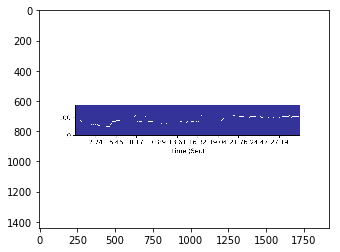

In [29]:
file_name,time_array, hz_array, midi_array= load_vocal_file(file_path="./lmd_matched/R/U/U/TRRUUHV128F4298B1B/")
load_midi_file(file_name)
midi_path = "./lpd_cleansed/"+"/".join(file_name.split('/')[2:-1])+'/'
print(midi_path)
test_song ,highest_list = test_file(midi_path)

(15, 24672)


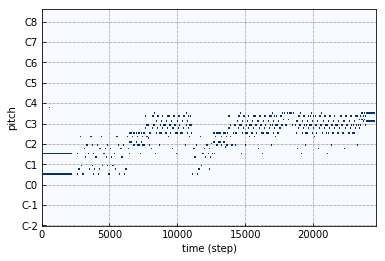

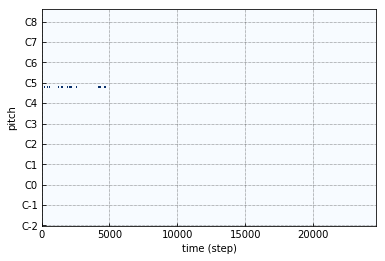

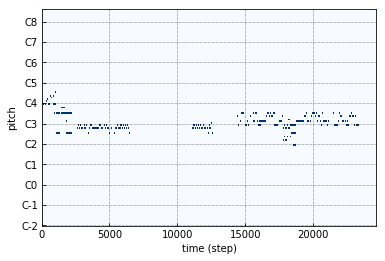

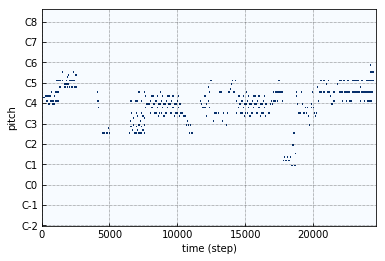

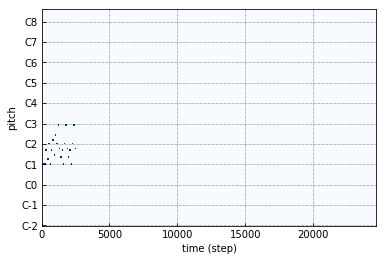

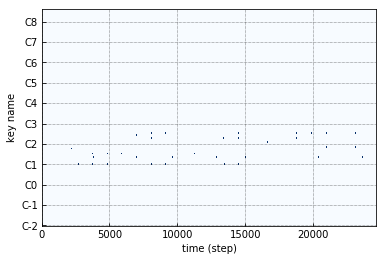

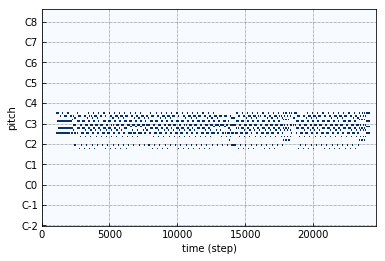

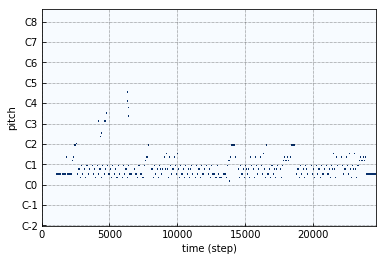

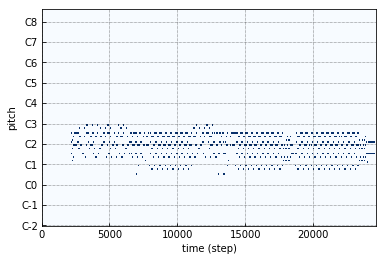

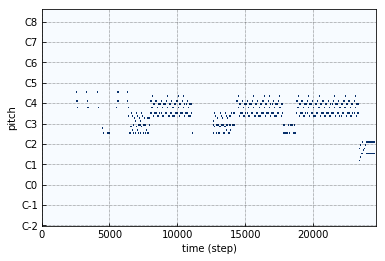

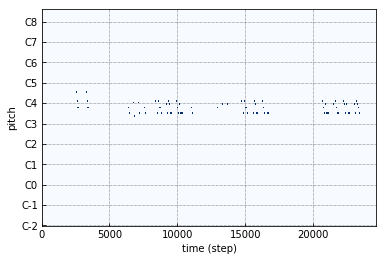

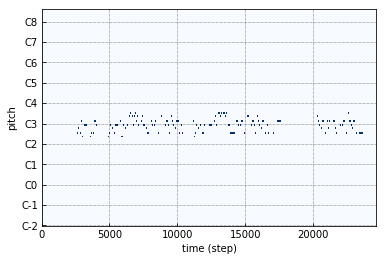

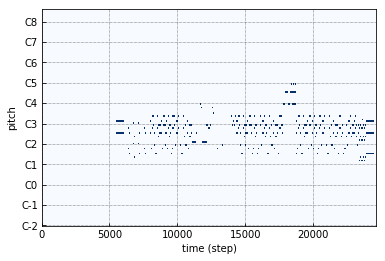

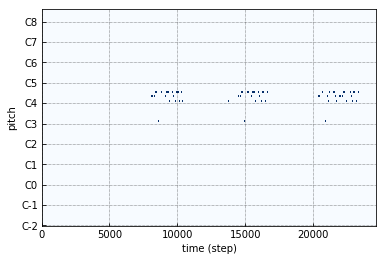

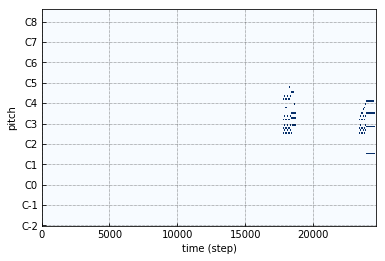

In [239]:
print(highest_list.shape)
for x in range(highest_list.shape[0]):
    test_song.tracks[x].plot()

In [241]:
matched_track,cost_array,matched_path,matched_acc_cost,start_pos, end_pos= process_one_song(midi_array, highest_list,debug=1)

track num:  0
cost:  82980.1972335855
--- 26.086555242538452 seconds ---


KeyboardInterrupt: 

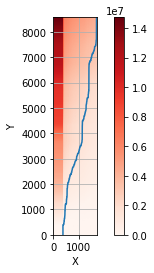

In [190]:
# x = midi_array[0:2500]
# y = highest_list[2,3000:5000]
# print(start_pos,end_pos)
path_x = [point[0] for point in matched_path]
path_y = [point[1] for point in matched_path]
distance_cost_plot(matched_acc_cost)
plt.plot(path_x, path_y)

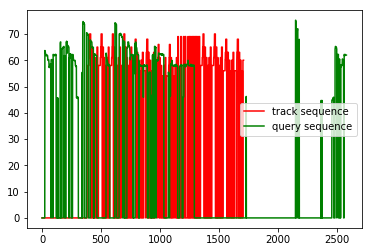

In [191]:
plt.plot(highest_list[matched_track,int(start_pos):end_pos],'r', label='track sequence')
plt.plot(midi_array, 'g', label='query sequence')
plt.legend();

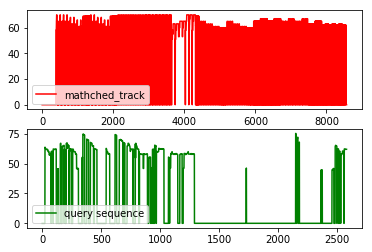

In [192]:
plt.subplot(2,1,1)
plt.plot(highest_list[matched_track],'r',label='mathched_track')
plt.legend()
plt.subplot(2,1,2)
plt.plot(midi_array,'g',label="query sequence")
plt.legend()

7


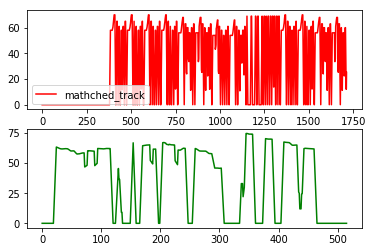

In [193]:
midi_paa = paa(midi_array,5)
print(matched_track)
matched_paa = paa(highest_list[matched_track,:],5)
plt.subplot(2,1,1)
plt.plot(matched_paa,'r',label='mathched_track')
plt.legend()
plt.subplot(2,1,2)
plt.plot(midi_paa,'g',label="query sequence")

In [160]:


midi_smooth,highest_smooth = smooth(midi_array,highest_list)
    

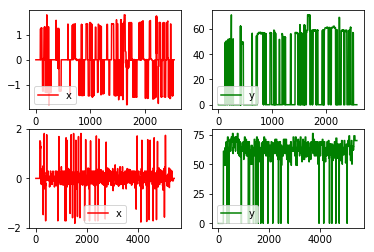

In [161]:
plt.subplot(2,2,1)
plt.plot(midi_smooth,'r', label='x')
# plt.plot(midi_array, 'g', label='y')
plt.legend()
plt.subplot(2,2,2)
plt.plot(midi_array, 'g', label='y')
plt.legend()
plt.subplot(2,2,3)
plt.plot(highest_smooth,'r', label='x')
plt.legend()
plt.subplot(2,2,4)
plt.plot(highest_list[2,:],'g',label='y')
plt.legend()

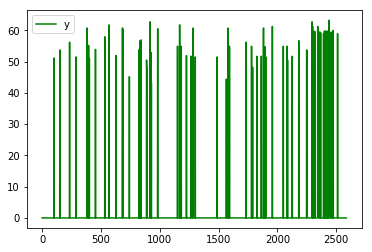

In [142]:
def load_midi_files():
    

In [ ]:
tup1 = input()